In [1]:
import math, pickle, os, copy, sys, scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from utils_pv import *
from samples.data_sim import PVDataset
from feature_selection import tune_pacf, rfecv_selection
from samples.data_sim import remove_feature

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)


In [2]:
exp_name = 'PV_UniModal'
filename_env = os.getcwd() + '/../../saved_results/' + exp_name + '_env' 
file = open(filename_env, 'rb')
print(filename_env)
env_dict = pickle.load(file)
msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients'])
print(msg)
file.close()
print('\n'+env_dict['info'])

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
print('number of features = {:2.0f}'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[1]))

/home/mahrokhg/Cloned_FL/Synthetic_PV_Profiles/samples/PV/../../saved_results/PV_UniModal_env


EOFError: Ran out of input

In [ ]:
# reconstruct houses
from house_pv import reconstruct_house
scenario_name_recons='5y'
clients_subset = [12, 14, 15, 17, 22]
houses = [None] * env_dict['num_clients']
for client_num in clients_subset:
    houses[client_num] = reconstruct_house(
                            env_dict=env_dict, 
                            client_num=client_num, 
                            scenario_name=scenario_name_recons)
print('[INFO] reconstructed the ' + scenario_name_recons + ' scenario.')


[INFO] reconstructed the 5y scenario.


# Part 1: station irrad relevance and delay analysis
Weather station direct and diffuse irradiation added to features of all houses
* Irradiation measured at a weather station not at each house => economically feasible
* Effect of including irradiation from weather station
* Do lags add more information?
    ** fit a linear model to 5 years of data, compare accuracies
* Using irradiation at t to predict power at t+1 vs. "predicted" irradiation at t+1 to predict power at t+1
    ** removing the need to another prediction model for the irradiation


### Results:
---------- LINEAR AND RIDGE REGRESSION WITHOUT GP ---------- <br>
sml<br>
with lags mean validation RMSE: 12.91 +/- 12.27<br>
no lags mean validation RMSE: 20.64 +/- 19.00<br>
no irradiation mean validation RMSE: 13.72 +/- 12.96<br>
delayed irradiation mean validation RMSE: 13.02 +/- 12.39<br>
1y<br>
with lags mean validation RMSE: 11.55 +/- 11.19<br>
no lags mean validation RMSE: 20.50 +/- 18.88<br>
no irradiation mean validation RMSE: 12.69 +/- 12.00<br>
delayed irradiation mean validation RMSE: 11.57 +/- 11.22<br>
5y<br>
with lags mean validation RMSE: 11.47 +/- 11.27<br>
no lags mean validation RMSE: 20.43 +/- 18.93<br>
no irradiation mean validation RMSE: 12.28 +/- 11.88<br>
delayed irradiation mean validation RMSE: 11.50 +/- 11.30<br>
15y<br>
with lags mean validation RMSE: 11.48 +/- 11.28<br>
no lags mean validation RMSE: 20.43 +/- 18.93<br>
no irradiation mean validation RMSE: 12.23 +/- 11.70<br>
delayed irradiation mean validation RMSE: 11.50 +/- 11.32<br>

In [ ]:
run_cell = False
if run_cell:
    from model_training.search_models import best_lin_reg
    normalize_data=True
    verbose=False

    num_clients=24
    city_names = ['Lausanne']
    env_dict_with_lags = {'city_names':city_names,
                'num_clients': num_clients, 'num_modes': len(city_names),
                'tilt_std': 5, 'az_std':15, 'weather_dev':0.1,
                'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':0.6,
                'module_name': get_available_modules('sandia')[0:num_clients],
                'inverter_name': get_available_inverters('cec')[0:num_clients],
                'lags':None, 'months':[3,4], 'hours':np.arange(7, 17), 
                'years':np.arange(2014, 2020), # 5 years of data
                'use_station_irrad_direct':True, 'use_station_irrad_diffuse':True,
                'delay_irrad':False, # this env uses predicted irrad
                'train_scenarios':{'sml':{'m_train':50, 'train_years':[2018], 'exclude_last_year':True},
                                '1y':{'m_train':None, 'train_years':[2018], 'exclude_last_year':True},
                                '5y':{'m_train':None, 'train_years':np.arange(2014, 2019), 'exclude_last_year':True},
                                '15y':{'m_train':None, 'train_years':None, 'exclude_last_year':True}}}
    env_dict_with_lags = PVDataset(env_dict_with_lags).generate_clients_data()

    env_dict_no_lags = copy.deepcopy(env_dict_with_lags)
    env_dict_no_irrad = copy.deepcopy(env_dict_with_lags)
    env_dict_delayed = copy.deepcopy(env_dict_with_lags)

    # features to keep 
    inds_to_keep_no_lags, inds_to_keep_no_irrad = [], []
    for ind, feature_name in enumerate(env_dict_with_lags['feature_names']):
        if not feature_name.startswith('lag'):
            inds_to_keep_no_lags.append(ind)
        if not feature_name.startswith('station_irrad'):
            inds_to_keep_no_irrad.append(ind)
    # features to delay for delayed irrads
    cols_to_delay=[]
    for ind, feature_name in enumerate(env_dict_delayed['feature_names']):
        if feature_name.startswith('station_irrad'):
            cols_to_delay.append(ind)

    # only keep the selected features
    for client_num in np.arange(env_dict_with_lags['num_clients']):
        for scenario in env_dict_with_lags['train_scenarios']:
            x_train, y_train, x_valid, y_valid = env_dict_with_lags['train_scenarios'][scenario]['clients_data'][client_num]
            # no lags
            x_train_no_lags = x_train[:, inds_to_keep_no_lags]
            x_valid_no_lags = x_valid[:, inds_to_keep_no_lags]
            env_dict_no_lags['train_scenarios'][scenario]['clients_data'][client_num] = (x_train_no_lags, y_train, x_valid_no_lags, y_valid)
            # no irrad
            x_train_no_irrad = x_train[:, inds_to_keep_no_irrad]
            x_valid_no_irrad = x_valid[:, inds_to_keep_no_irrad]
            env_dict_no_irrad['train_scenarios'][scenario]['clients_data'][client_num] = (x_train_no_irrad, y_train, x_valid_no_irrad, y_valid)
            # delayed irrad
            # NOTE: one less sample
            x_train_dalayed, y_train_dalayed = x_train[1:, :], y_train[1:]
            x_valid_dalayed, y_valid_dalayed = x_valid[1:, :], y_valid[1:]
            x_train_dalayed[:, cols_to_delay] = x_train[:-1, cols_to_delay]
            x_valid_dalayed[:, cols_to_delay] = x_valid[:-1, cols_to_delay]
            env_dict_delayed['train_scenarios'][scenario]['clients_data'][client_num] = (x_train_dalayed, y_train_dalayed, 
                                                            x_valid_dalayed, y_valid_dalayed)


    env_dict_no_lags['feature_names'] = [x for i, x in enumerate(env_dict_no_lags['feature_names']) if i in inds_to_keep_no_lags]
    env_dict_no_irrad['feature_names'] = [x for i, x in enumerate(env_dict_no_irrad['feature_names']) if i in inds_to_keep_no_irrad]



    print('\n---------- LINEAR AND RIDGE REGRESSION ----------')
    env_names = ['with lags', 'no lags', 'no irradiation', 'delayed irradiation']
    envs = [env_dict_with_lags, env_dict_no_lags, env_dict_no_irrad, env_dict_delayed]
    for scenario_name in env_dict_with_lags['train_scenarios'].keys():
        print(scenario_name)
        for env_tmp, env_name in zip(envs, env_names):
            # Linear regression without GP
            valid_rmses_linreg = np.zeros(num_clients)
            for client_num in np.arange(num_clients):
                if verbose:
                    print('\nClient {:2.0f}'.format(client_num))
                _, valid_rmses_linreg[client_num] = best_lin_reg(clients_data=env_tmp['train_scenarios'][scenario_name]['clients_data'], 
                            client_num=client_num, logger=None, normalize_data=normalize_data, verbose=verbose) 

            print(env_name + ' mean validation RMSE: {:2.2f} +/- {:.2f}'.format(np.mean(valid_rmses_linreg),
                                                                    1.96*np.std(valid_rmses_linreg)))


## 2.2 Checking modelling assumptions
* multicollinearity
* is data from each house homogeneous and i.i.d?
* are houses independent?

### 2.2.1 multicollinearity
* VIF: measure of multicollinearity among the independent variables
* multicollinearity does not reduce the explanatory power of the model, but reduces the statistical significance of the independent variables
* VIF=1 (no multicol), VIF<5 (ok), VIF>10 (strong)
conclusion: remove lag 4 to reduce multicollinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

high_vif_feat = []
for train_scenario in env_dict['train_scenarios'].keys():
    print('\n Train scenario: ', train_scenario)
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = env_dict['feature_names']
    for client_num in np.arange(env_dict['num_clients']):
        # get train data
        X_train = env_dict['train_scenarios'][train_scenario]['clients_data'][client_num][0]
        # normalize train data
        X_train = (X_train - np.mean(X_train, axis=0))/ np.std(X_train, axis=0)
        # calculating VIF for each feature
        vif_data[str(client_num)] = [variance_inflation_factor(X_train, i)
                                for i in range(len(env_dict['feature_names']))]

    vif_data["average"] = vif_data.mean(axis=1)
    high_vif_this_scen = vif_data.loc[vif_data.loc[:, "average"]>10, 'feature'].values
    print('features with av. VIF>10: ', high_vif_this_scen)
    [high_vif_feat.append(x) for x in high_vif_this_scen if not x in high_vif_feat]
    


 Train scenario:  sml


/tmp/ipykernel_1828299/2745311351.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vif_data["average"] = vif_data.mean(axis=1)


features with av. VIF>10:  ['lag 1' 'lag 3' 'lag 4' 'lag 18']

 Train scenario:  1y


/tmp/ipykernel_1828299/2745311351.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vif_data["average"] = vif_data.mean(axis=1)


features with av. VIF>10:  ['lag 1' 'lag 4']

 Train scenario:  5y


/tmp/ipykernel_1828299/2745311351.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vif_data["average"] = vif_data.mean(axis=1)


features with av. VIF>10:  ['lag 1' 'lag 2' 'lag 3' 'lag 4' 'lag 18']

 Train scenario:  15y
features with av. VIF>10:  ['lag 1' 'lag 2' 'lag 3' 'lag 4' 'lag 18']


/tmp/ipykernel_1828299/2745311351.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vif_data["average"] = vif_data.mean(axis=1)


In [ ]:
# reduce VIF by removing one feature based on 15y data
train_scenario = '1y'
min_num_high_vif = len(high_vif_feat)

for feat_to_remove in high_vif_feat:
    # VIF dataframe
    vif_data = pd.DataFrame()
    all_feat = copy.deepcopy(env_dict['feature_names'])
    all_feat.remove(feat_to_remove)
    vif_data["feature"] = all_feat
    feat_to_keep_ind = np.setdiff1d(
        np.arange(len(env_dict['feature_names'])),
        np.array(env_dict['feature_names'].index(feat_to_remove))
        )
    for client_num in np.arange(env_dict['num_clients']):
        # get train data
        X_train = env_dict['train_scenarios'][train_scenario]['clients_data'][client_num][0]
        # remove feat
        X_train = X_train[:, feat_to_keep_ind]
        # normalize train data
        X_train = (X_train - np.mean(X_train, axis=0))/ np.std(X_train, axis=0)
        # calculating VIF for each feature
        vif_data[str(client_num)] = [variance_inflation_factor(X_train, i)
                                for i in range(X_train.shape[1])]

    vif_data["average"] = vif_data.mean(axis=1)
    print('\nRemoving feature ', feat_to_remove)
    high_vif_red = vif_data.loc[vif_data.loc[:, "average"]>10, 'feature'].values
    print('features with av. VIF>10: ', high_vif_red)
    print('{:2.0f} features with av. VIF>5'.format(
        len(vif_data.loc[vif_data.loc[:, "average"]>5, 'feature'].values)))

/tmp/ipykernel_1828299/3968648274.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vif_data["average"] = vif_data.mean(axis=1)



Removing feature  lag 1
features with av. VIF>10:  ['lag 4']
 6 features with av. VIF>5


/tmp/ipykernel_1828299/3968648274.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vif_data["average"] = vif_data.mean(axis=1)



Removing feature  lag 3
features with av. VIF>10:  ['lag 1']
 7 features with av. VIF>5


/tmp/ipykernel_1828299/3968648274.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vif_data["average"] = vif_data.mean(axis=1)



Removing feature  lag 4
features with av. VIF>10:  ['lag 1']
 6 features with av. VIF>5


/tmp/ipykernel_1828299/3968648274.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vif_data["average"] = vif_data.mean(axis=1)



Removing feature  lag 18
features with av. VIF>10:  ['lag 1' 'lag 4']
 6 features with av. VIF>5

Removing feature  lag 2
features with av. VIF>10:  ['lag 1']
 7 features with av. VIF>5


/tmp/ipykernel_1828299/3968648274.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vif_data["average"] = vif_data.mean(axis=1)


### 2.2.2 is data from each house homogeneous and i.i.d?


### covariate shift between train and test samples
Is the dist of each feature in the train and test sets the same?
* create a random sample of training and test data, divide to train and val 
* train a model taking one feature at a time to classify samples for being a part of the test dataset 
* compute AUC-ROC for each feature  on validation set, if greater than 0.80, we classify that feature as drifting.

T2m 0.8885245901639345


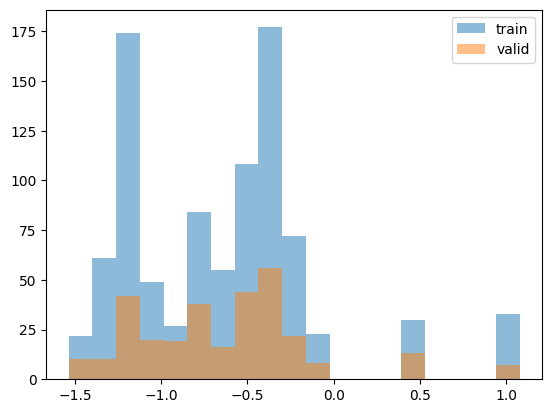

WS10m 0.9704918032786886


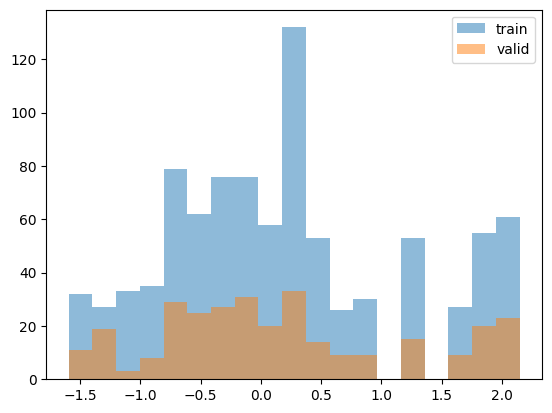

station_irrad_direct_prev 0.8426229508196721


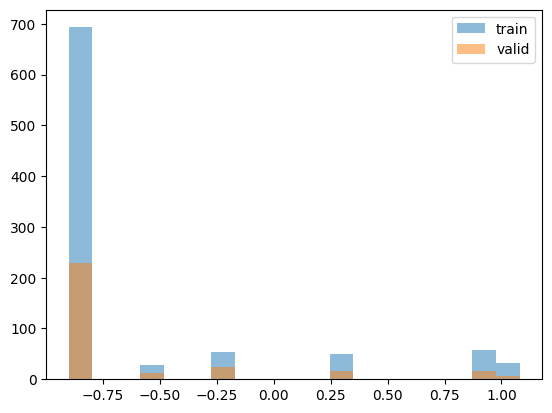

lag 1 0.8754098360655738


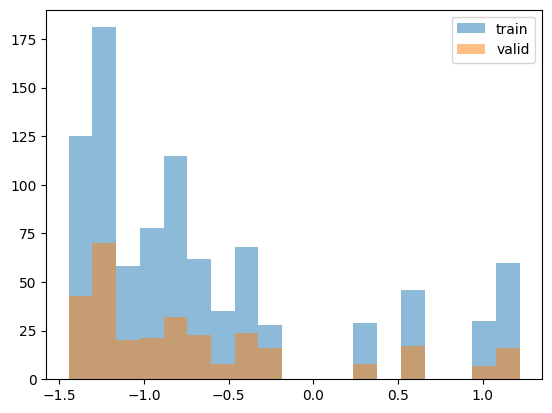

lag 19 0.8065573770491803


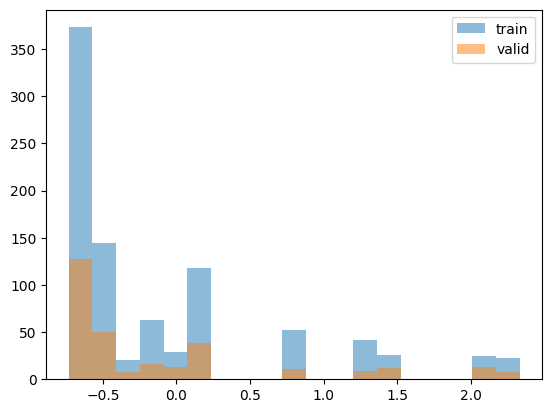

lag 23 0.9704918032786886


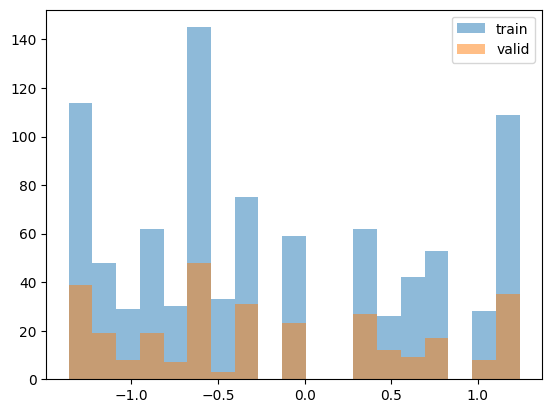

lag 120 1.0


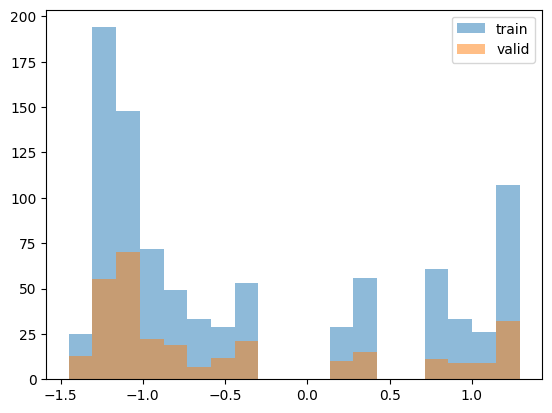

lag 121 0.9475409836065574


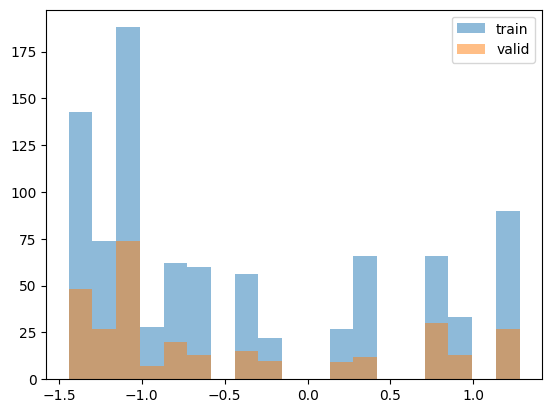

IndexError: index 16 is out of bounds for axis 1 with size 16

In [ ]:
## importing libraries
from pandas import Series, DataFrame

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

train_scenario = '1y'
client_num = 0
use_cv = False

# get train data
X_train, _, X_valid, _ = env_dict['train_scenarios'][train_scenario]['clients_data'][client_num]
# normalize both sets with train stats
X_mean = np.mean(X_train, axis=0) 
X_std = np.std(X_train, axis=0) 
X_train = (X_train-X_mean)/X_std
X_valid = (X_valid-X_mean)/X_std 

# sample
num_samp = min(X_train.shape[0], X_valid.shape[0])
X_train = X_train[np.random.randint(low=0, high=X_train.shape[1], size=num_samp)]
X_valid = X_valid[np.random.randint(low=0, high=X_valid.shape[1], size=num_samp)]
assert X_train.shape==X_valid.shape

# creating a pd
df_train = pd.DataFrame(X_train, columns = env_dict['feature_names'])
df_train['is_valid'] = 0
df_valid = pd.DataFrame(X_valid, columns = env_dict['feature_names'])
df_valid['is_valid'] = 1
df = pd.concat((df_train, df_valid), axis=0).sample(frac=1) # shuffle

if use_cv:
    y = df.loc[:, 'is_valid'].to_numpy()
    df = df.drop('is_valid', axis=1)
    X = df.to_numpy()
else:
    # divide to train and valid
    num_train = int(2*num_samp*0.75)
    df_train = df.iloc[np.arange(num_train), :]
    df_valid = df.iloc[np.arange(num_train, 2*num_samp), :]
    y_train = df_train.loc[:, 'is_valid']
    y_valid = df_valid.loc[:, 'is_valid']
    X_train = df_train.drop('is_valid', axis=1).to_numpy()
    X_valid = df_valid.drop('is_valid', axis=1).to_numpy()

# modelling
model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
drop_list = []
for col_ind, col_name in enumerate(df.columns):
    if use_cv:
        score = cross_val_score(model, X[:, col_ind].reshape(-1, 1), y, cv=3, scoring='roc_auc')
        score = sum(score)/len(score)
    else:
        model.fit(X_train[:, col_ind].reshape(-1, 1), y_train)
        score = model.score(X_valid[:, col_ind].reshape(-1, 1), y_valid)
    if score>0.8:
        drop_list.append(col_name)
        print(col_name, np.mean(score))

        bins = np.linspace(min(X_train[:, col_ind]), max(X_train[:, col_ind]), 20)
        print(X_train[:, col_ind].shape, X_valid[:, col_ind].shape)
        plt.hist(X_train[:, col_ind], bins, alpha=0.5, label='train')
        plt.hist(X_valid[:, col_ind], bins, alpha=0.5, label='valid')
        plt.legend(loc='upper right')
        plt.show()

### 2.2.3 are houses independent?

# Part 3: Measuring Heterogeneity